In [1]:
import os
import random

import chainer
from chainer.dataset import convert
from sklearn.datasets import load_digits, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
#from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
plt.style.use('ggplot')
from PIL import Image, ImageDraw

from defCVAE_selfdata import CVAE
%matplotlib inline
%load_ext autoreload
%autoreload 2

# 訓練画像

image size:(140, 56)


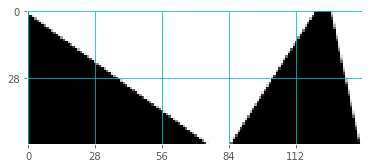

In [2]:
#Show iamge
IMG = Image.open("test_image.png")
plt.grid(c='c')
plt.xticks(np.arange(0,140,28))
plt.yticks(np.arange(0,56,28))
plt.imshow(np.asarray((IMG)))
print("image size:"+str(IMG.size))
img = Image.open("test_image.png").convert("L")

# 画像の切り出し関数

In [3]:
center_point_list = np.empty((1, 2))
for row in range(2):
    for col in range(5):
        c_point = (14+(28*col), 14*(row+1)+(row*14))
        center_point_list = np.vstack((center_point_list, c_point))
center_point_list = np.delete(center_point_list,0,0)

def cropImage(center_x, center_y, height, width):
    left = center_x - width/2
    upper = center_y - height/2
    right = center_x + width/2
    lower = center_y + height/2
    c_img = img.crop((left, upper, right, lower))
    carr = np.asarray(c_img)
    carr = carr.flatten()
    
    #print(c_img)
    carr = np.asarray(carr).astype(np.float32)
    return np.array(carr, dtype=np.float32)/255

def random_crop(DATA_NUM):
    image_list = np.empty(28*28,dtype=np.float32)
    labels = np.empty(2,dtype=np.int32)
    #print(image_list.size)
    for n in range(DATA_NUM):
        # choice 14 <= x <= 126 && 14 <= y <= 42
        randx = np.random.rand()*112 + 14
        randy = np.random.rand()*28 + 14
        c_image = cropImage(int(randx), int(randy), 28, 28)
        #print(c_image.shape)
        image_list = np.vstack((image_list, c_image))
        labels = np.vstack((labels,[randx/(28*5), randy/(25*2)]))
    image_list = np.delete(image_list, 0,axis=0)
    labels = np.delete(labels,0, axis=0)
    return image_list, labels

def random_crop_in_area(left, upper, right, lower, label):
    image_list = np.empty(28*28,dtype=np.float32)
    randx = np.random.randint(left, right)
    randy = np.random.randint(upper, lower)
    crop_img = cropImage(randx, randy, 28, 28)
    c_point = [[float(randx)/(28*5), float(randy)/(28*2)]]
    c_point = np.array(c_point, dtype=np.float32)
    return crop_img, label, c_point

def convert_axis(label, movement):
    m = movement
    p = center_point_list
    crop_area = []
    if label == 0:
        crop_area = (p[label][0], p[label][1], p[label][0]+m, p[label][1]+m)
    elif label == 1:
        crop_area = (p[label][0]-m, p[label][1], p[label][0]+m, p[label][1]+m)
    elif label == 2:
        crop_area = (p[label][0]-m, p[label][1], p[label][0]+m, p[label][1]+m)
    elif label == 3:
        crop_area =  (p[label][0]-m, p[label][1], p[label][0]+m, p[label][1]+m)
    elif label == 4:
        crop_area = (p[label][0]-m, p[label][1], p[label][0], p[label][1]+m)
    elif label == 5:
        crop_area =(p[label][0], p[label][1]-m, p[label][0]+m, p[label][1])
    elif label == 6:
        crop_area = (p[label][0]-m, p[label][1]-m, p[label][0]+m, p[label][1])
    elif label == 7:
        crop_area = (p[label][0]-m, p[label][1]-m, p[label][0]+m, p[label][1])
    elif label == 8:
        crop_area = (p[label][0]-m, p[label][1]-m, p[label][0]+m, p[label][1])
    else:
        crop_area = (p[label][0]-m, p[label][1]-m, p[label][0], p[label][1])
    return crop_area
'''
label=9
print(convert_axis(label,3))
print(center_point_list[label])
IMG = Image.open("test_image.png")
draw = ImageDraw.Draw(IMG)
for l in range(10):
    draw.rectangle((convert_axis(l,7)),fill=(0,129,129))
plt.xticks(np.arange(0,140,14))
plt.yticks(np.arange(0,56,14))
plt.imshow(np.asarray((IMG)))
#plt.clf()
#plt.imshow(img)
'''

'\nlabel=9\nprint(convert_axis(label,3))\nprint(center_point_list[label])\nIMG = Image.open("test_image.png")\ndraw = ImageDraw.Draw(IMG)\nfor l in range(10):\n    draw.rectangle((convert_axis(l,7)),fill=(0,129,129))\nplt.xticks(np.arange(0,140,14))\nplt.yticks(np.arange(0,56,14))\nplt.imshow(np.asarray((IMG)))\n#plt.clf()\n#plt.imshow(img)\n'

# 画像1枚の表示関数

In [4]:
def dispImage(img_vec, label_x, label_y):
    title = 'Label number is ('+ str(label_x) + ',' + str(label_y) + ')' 
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    plt.title(title)
    plt.show()

# 訓練データ生成

In [5]:
'''
train_one_class_data_num = 25
crop_area = 5
X_train = np.empty(28*28, dtype=np.float32)
L_train =np.empty(1,dtype=np.int32)
#print(L_train.shape)
for label in range(0,10):
    for c in range(0,train_one_class_data_num):
        left, upper, right, lower = convert_axis(label, crop_area)
        c_img, l = random_crop_in_area(left, upper, right, lower,label)
        X_train = np.vstack((X_train, c_img))
        L_train = np.vstack((L_train, l))
X_train = np.delete(X_train, 0,axis=0)
L_train = np.delete(L_train, 0,axis=0)

train_cnt = len(X_train)
l_train_half = np.concatenate([L_train[0:(train_cnt/2)], np.ones((train_cnt-(train_cnt/2),1))*(-1)]).astype('int32')
l_train_half = np.ravel(l_train_half)
print(l_train_half.dtype)
'''
crop_area = 2
test_one_class_data_num = 20
X_dtest = np.empty(28*28, dtype=np.float32)
L_dtest =np.empty(1,dtype=np.int32)
A_test =np.empty(2,dtype=np.float32)
for label in range(0,10):
    for c in range(0,test_one_class_data_num):
        left, upper, right, lower = convert_axis(label, crop_area)
        c_img, l, a = random_crop_in_area(left, upper, right, lower,label)
        #print(a.dtype)
        X_dtest = np.vstack((X_dtest, c_img))
        L_dtest = np.vstack((L_dtest, l))
        A_test = np.vstack((A_test, a))
X_dtest = np.delete(X_dtest, 0,axis=0) #area no gazou
L_dtest = np.delete(L_dtest, 0,axis=0) #area no label 0-9
L_dtest = np.ravel(L_dtest)
A_test = np.delete(A_test, 0, axis=0)
#print(A_test[0])
#  list : [image label]  
Xy_dtest = [(x, y) for x, y in zip(X_dtest, A_test)] ####################
print(A_test[21])
print(L_dtest[21])






train_im, train_la = random_crop(5000)
test_im, test_la = random_crop(300)
X_train = train_im
L_train = train_la.astype('float32')
X_test = test_im
L_test = test_la.astype('float32')
train_cnt = len(X_train)
Xy_train = [(x, y) for x, y in zip(X_train, L_train)]
Xy_test = [(x, -1) for x, y in zip(X_test, L_test)]
#Xy_dtest = [(x, y) for x, y in zip(X_test, L_test)]

[0.29285714 0.26785713]
1


# 訓練データのノイズかけ

In [20]:
def chageBrightness(data_list):
    data_num = len(data_list)
    print(data_num)
    dist_list = np.empty(28*28)
    for l in range(data_num):
        rand_gain = np.random.uniform(-0.3, 0.3, (28*28))
        data_list[l] = data_list[l]+rand_gain
        # 0 miman
        data_list[l] = np.where(data_list[l] > 1, 1, data_list[l])
        # 1 izyou
        data_list[l] = np.where(data_list[l] < 0, 0, data_list[l])
        dist_list = np.vstack((dist_list, data_list[l]))
    dist_list = np.delete(dist_list,0,0)
    return dist_list

'''
test = np.copy(X_train[13:15])
l_test = [[1,1],[1,1]]

for l in range(28*28):
    test[0][l] = test[0][l]-test[0][l]*0.1
    if(test[0][l]>1):
        test[0][l] = 1
    elif(test[0][l]<0):
        test[0][l] = 0
#print(test[0])
#print(X_train[13])

print(test[0][20])
print(X_train[13][20])

dispTrainData(test, l_test)
dispTrainData(X_train[13:14], L_train[13:14])


data_list = chageBrightness(test)

dispTrainData(test, l_test)
dispTrainData(X_train[13:14], L_train[13:14])
print(data_list[0][20])
print(X_train[13][20])
'''

X_train = chageBrightness(X_train)

5000


# 訓練データの確認

****************0***********************


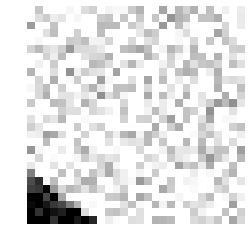

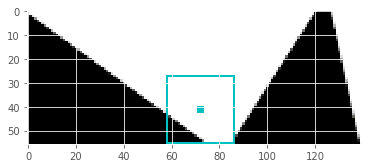

float64


In [21]:
t_img = Image.open("test_image.png")
def dispTrainData(img_list, label_list):
    for c in range(len(img_list)):
        print("****************{}***********************".format(c))
        plt.clf()
        img = t_img.copy()
        x = label_list[c][0]*28*5
        y = label_list[c][1]*28*2
        pixels = (img_list[c] * 256).reshape((28, 28))
        plt.imshow(pixels, 'gray',vmin=0.0, vmax=256)
        plt.axis("off")
        plt.show()
        draw = ImageDraw.Draw(img)
        draw.ellipse((x-1, y-1, x+1, y+1), (0,192,192), (0,192,192))
        draw.rectangle([(x-14,y-14),(x+14,y+14)],outline=(0,192,192))
        plt.imshow(img)
        plt.show()

#dispTrainData(X_train[10:30], L_train[10:30])
dispTrainData(X_train[16:17], L_train[16:17])
print(X_train[16].dtype)

In [7]:
def train(input_size, hidden_size, z_size, label_size, minibatch_size, epoch_num, X_train, output):
    model = CVAE(input_size, z_size, hidden_size, label_size)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)
    
    train_iter = chainer.iterators.SerialIterator(X_train, minibatch_size)
    for epoch in range(0, epoch_num):
        sum_loss = 0
        sum_rec_loss = 0
        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        optimizer.update(model.get_loss_func(C=0.1, k=5), x, t)
        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)
        
    chainer.serializers.save_npz(output, model)
    print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / train_cnt, sum_rec_loss / train_cnt))

def test_plot(model, X_test, L_test):
    
    colors_dict = {}
    markers = ["*", "s", "v", "^", "8", "o", "p", "D", "p", "d"]
    cm = plt.get_cmap('jet')
    for dic in range(0,10):
        colors_dict[dic] = cm(1.*dic/10)
        train_iter = chainer.iterators.SerialIterator(X_test, len(X_test), repeat=False, shuffle=False)
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        #np.array(x_array, dtype=np.float32)
        print(x_array.dtype)
        print(t_array.dtype)
        x = chainer.Variable(x_array)
        #print(t_array)
        t = chainer.Variable(t_array)
        #print(x.shape)
        #print(t.shape)
        x_mu, log_var = model.encode(x, t)
        print('mu size:{}'.format(x_mu.shape))
        print('logvar size:{}'.format(log_var.shape))
    data_dict = {}
    for x, y in zip(x_mu.data, L_test):
        if y in data_dict:
            data_dict[y].append(x)
        else:
            data_dict[y] = [x]
    #plt.axes(axisbg='w')
    for y in range(0, 10):
        data = data_dict[y]
        xs  = [row[0] for row in data]
        ys = [row[1] for row in data]
        plt.scatter(xs, ys, s=150, c=colors_dict[y],marker=markers[y], label=y)
    plt.title("CVAE")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=13)
    plt.grid()
    
def test_decode(model, x, label, output):
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_v = chainer.Variable(x)
        label_v = chainer.Variable(label)
        y_v = model(x_v, label_v)
        print('出力')
        pixels = (y_v.data * 256).reshape((28, 28))
        plt.imshow(pixels, cmap='gray',vmin=0.0)
        plt.axis("off")
        plt.show()
        #plt.imsave(output, pixels, cmap='gray')

# 訓練

In [22]:
#main
EPOCH_NUM = 5000
INPUT_SIZE = 784
HIDDEN_SIZE = 128
MINIBATCH_SIZE = 100
LABEL_SIZE = 2
Z_SIZE = 2

scores = {}
MODEL_PATH = './CVAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)

train(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    z_size=Z_SIZE,
    label_size=LABEL_SIZE,
    minibatch_size=MINIBATCH_SIZE,
    epoch_num=EPOCH_NUM,
    X_train=Xy_train,
    output=MODEL_PATH
)

train mean loss=1.2635298156738282, mean reconstruction loss=1.2287757110595703


# 訓練した重みを使って文字を生成

入力


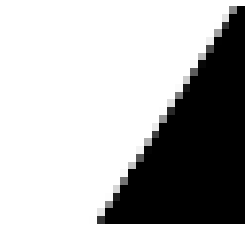

[[0.67577565 0.7320076 ]]
[[0. 0.]]
出力


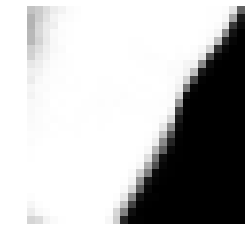

入力


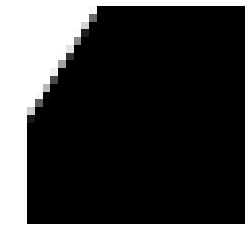

[[0.81676215 0.64921176]]
[[0. 0.]]
出力


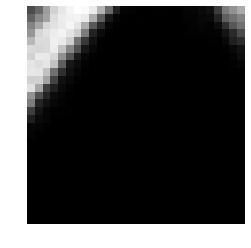

入力


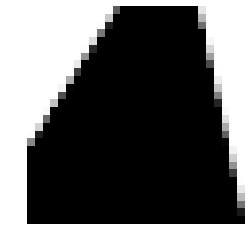

[[0.8632878 0.3971352]]
[[0. 0.]]
出力


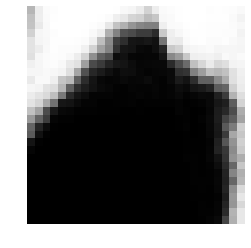

入力


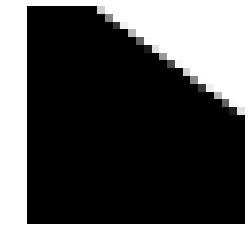

[[0.161493  0.5578712]]
[[0. 0.]]
出力


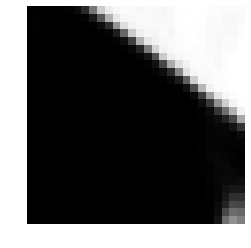

入力


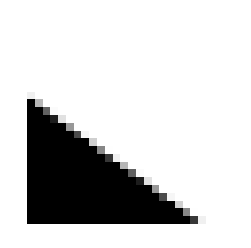

[[0.40414923 0.6925265 ]]
[[0. 0.]]
出力


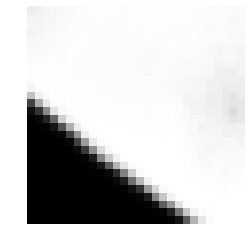

入力


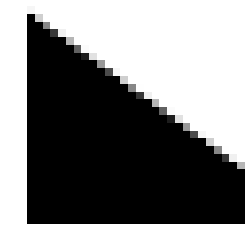

[[0.2941437  0.68336344]]
[[0. 0.]]
出力


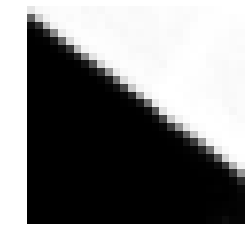

入力


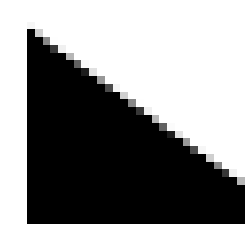

[[0.37436587 0.8091864 ]]
[[0. 0.]]
出力


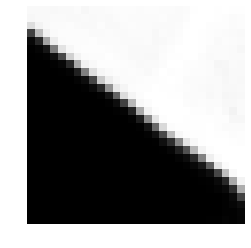

入力


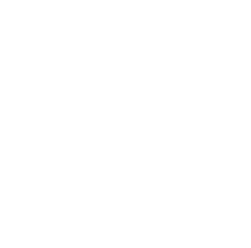

[[0.5835689 0.4729539]]
[[0. 0.]]
出力


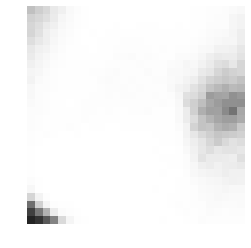

入力


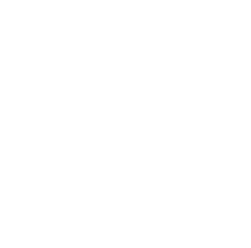

[[0.5503687  0.37823215]]
[[0. 0.]]
出力


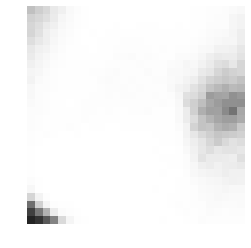

入力


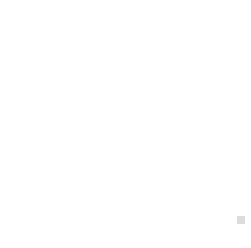

[[0.61203885 0.43408203]]
[[0. 0.]]
出力


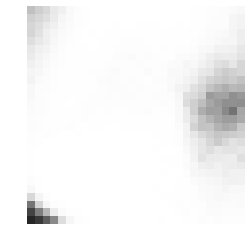

入力


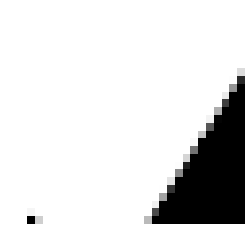

[[0.61055475 0.81997705]]
[[0. 0.]]
出力


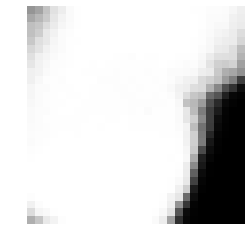

入力


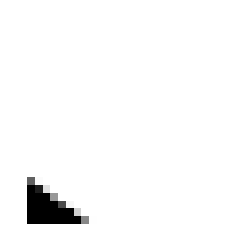

[[0.4187784 0.5023043]]
[[0. 0.]]
出力


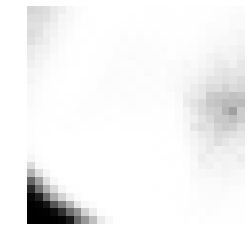

入力


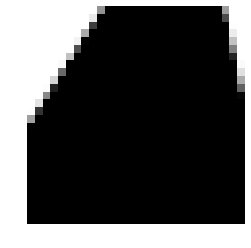

[[0.8481287 0.5115303]]
[[0. 0.]]
出力


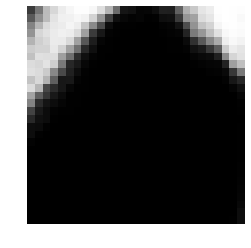

入力


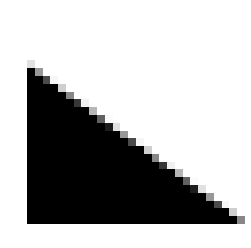

[[0.43410763 0.8200785 ]]
[[0. 0.]]
出力


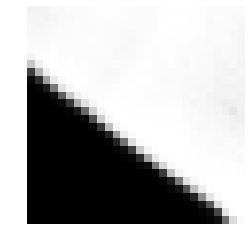

入力


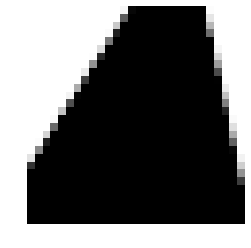

[[0.85421485 0.37049347]]
[[0. 0.]]
出力


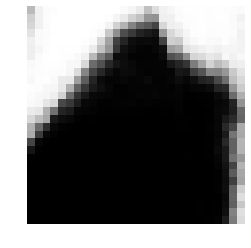

入力


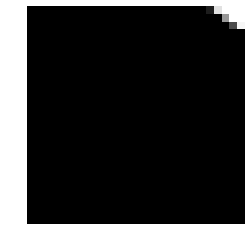

[[0.10299823 0.6413239 ]]
[[0. 0.]]
出力


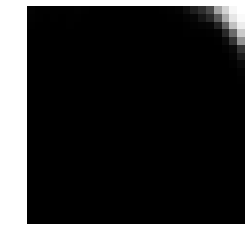

入力


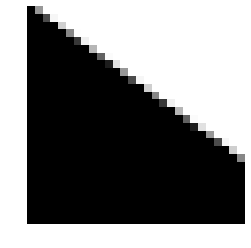

[[0.35465723 0.8254687 ]]
[[0. 0.]]
出力


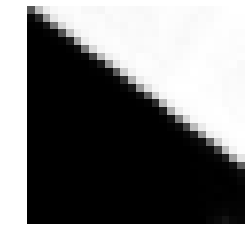

入力


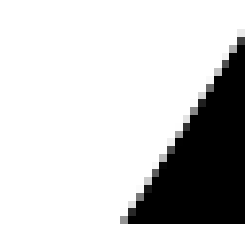

[[0.7101696  0.47391465]]
[[0. 0.]]
出力


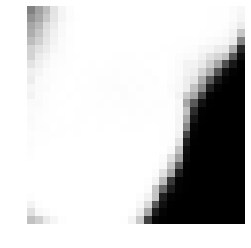

入力


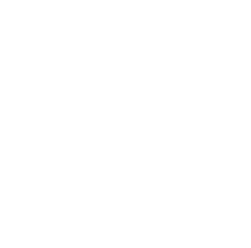

[[0.48322174 0.31329706]]
[[0. 0.]]
出力


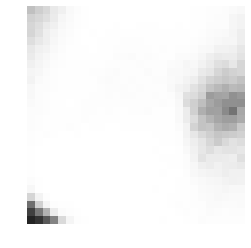

入力


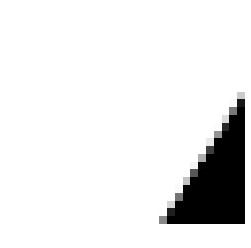

[[0.62161833 0.69188845]]
[[0. 0.]]
出力


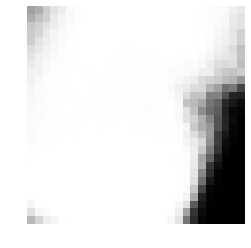

入力


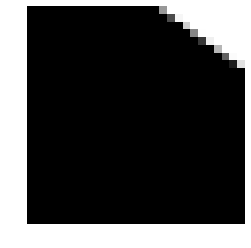

[[0.23844944 0.82955074]]
[[0. 0.]]
出力


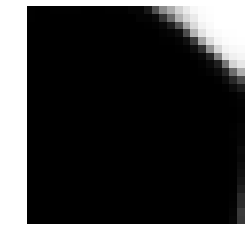

入力


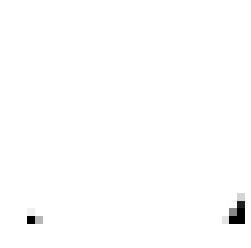

[[0.5615642 0.7165009]]
[[0. 0.]]
出力


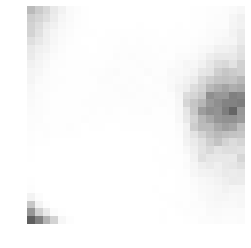

入力


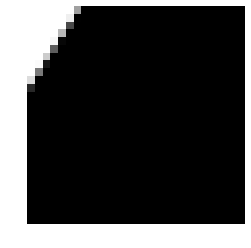

[[0.80406916 0.79797816]]
[[0. 0.]]
出力


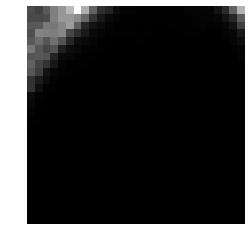

入力


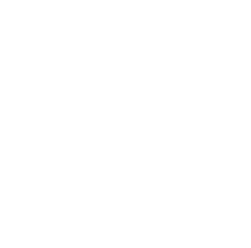

[[0.56755066 0.51512593]]
[[0. 0.]]
出力


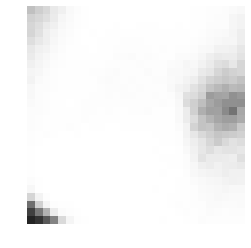

入力


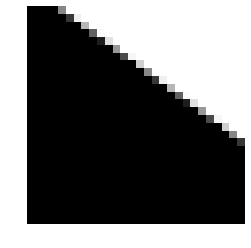

[[0.27994776 0.73420304]]
[[0. 0.]]
出力


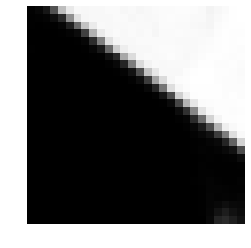

入力


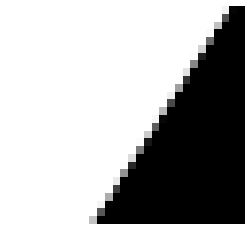

[[0.7134539 0.5895924]]
[[0. 0.]]
出力


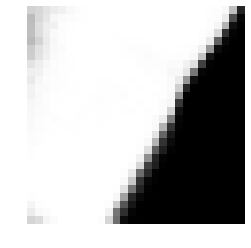

入力


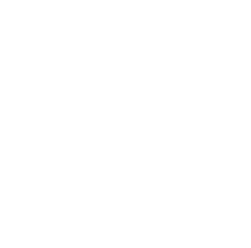

[[0.44770792 0.40848607]]
[[0. 0.]]
出力


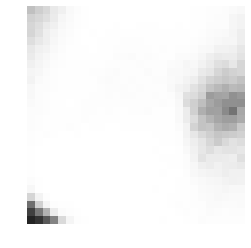

入力


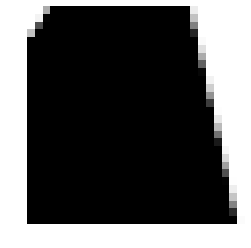

[[0.882909  0.5627589]]
[[0. 0.]]
出力


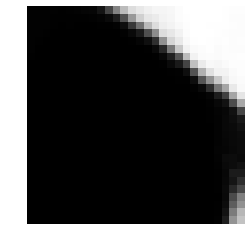

入力


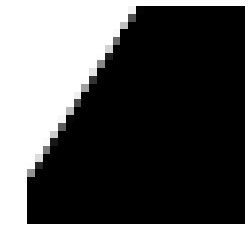

[[0.79775256 0.59121484]]
[[0. 0.]]
出力


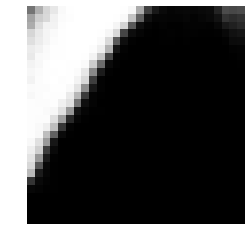

入力


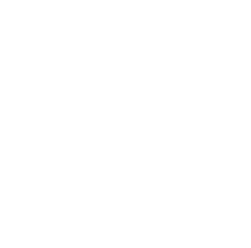

[[0.49249277 0.29240564]]
[[0. 0.]]
出力


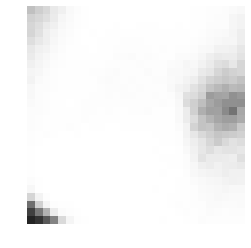

入力


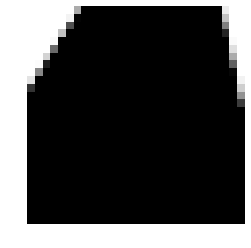

[[0.8513123  0.57613635]]
[[0. 0.]]
出力


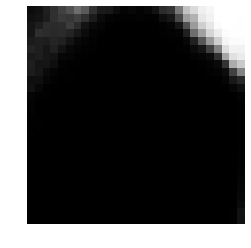

入力


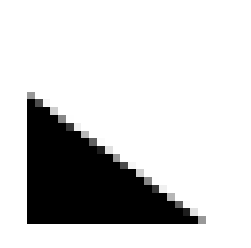

[[0.28291437 0.45330584]]
[[0. 0.]]
出力


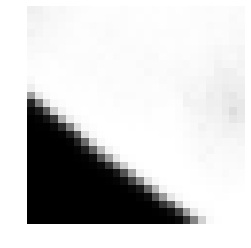

入力


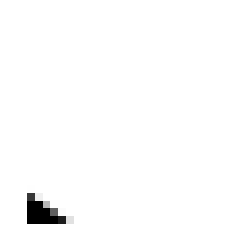

[[0.39891413 0.4271993 ]]
[[0. 0.]]
出力


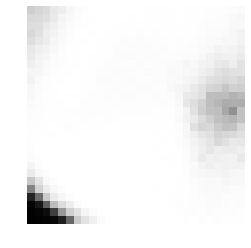

入力


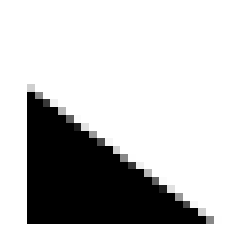

[[0.22781889 0.3575851 ]]
[[0. 0.]]
出力


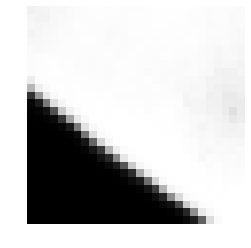

入力


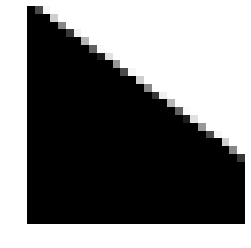

[[0.12662755 0.3766515 ]]
[[0. 0.]]
出力


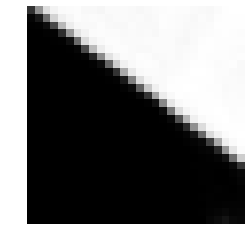

入力


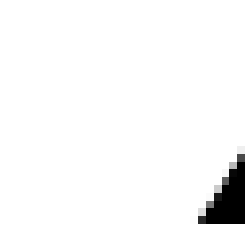

[[0.6457099  0.44637597]]
[[0. 0.]]
出力


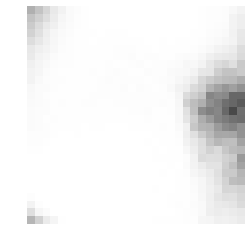

入力


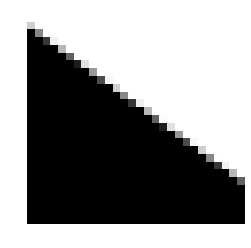

[[0.22843905 0.5022292 ]]
[[0. 0.]]
出力


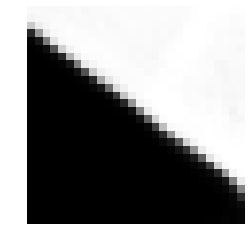

入力


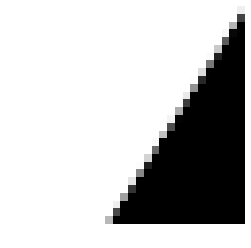

[[0.75772166 0.30854574]]
[[0. 0.]]
出力


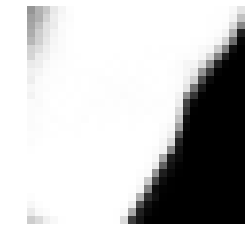

入力


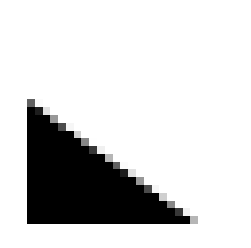

[[0.25787595 0.3800538 ]]
[[0. 0.]]
出力


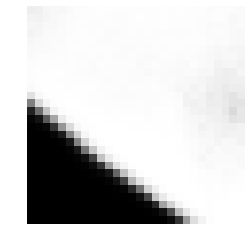

入力


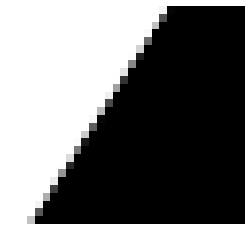

[[0.7657591  0.59509104]]
[[0. 0.]]
出力


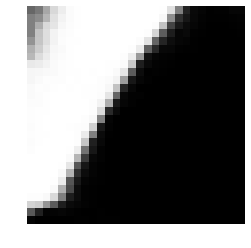

入力


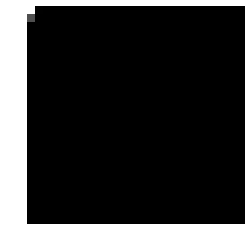

[[0.8415983  0.80703866]]
[[0. 0.]]
出力


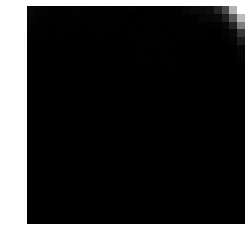

入力


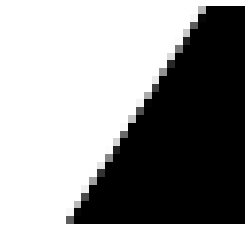

[[0.7901328  0.35323203]]
[[0. 0.]]
出力


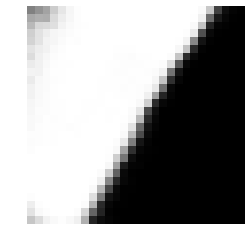

入力


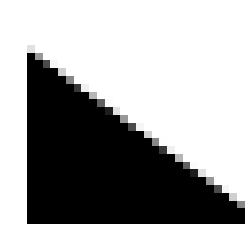

[[0.2778772 0.5425753]]
[[0. 0.]]
出力


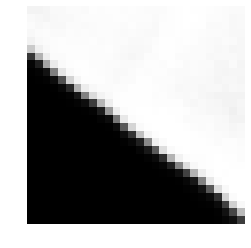

入力


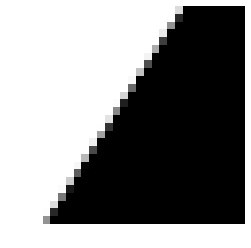

[[0.78122413 0.4762195 ]]
[[0. 0.]]
出力


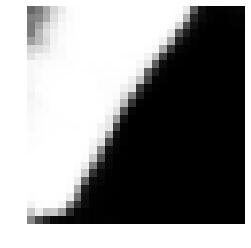

入力


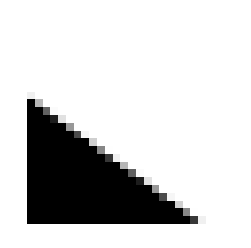

[[0.32217804 0.53739476]]
[[0. 0.]]
出力


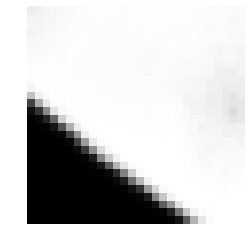

入力


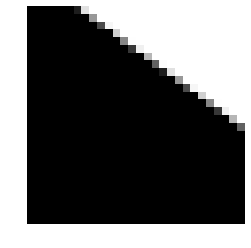

[[0.30267465 0.8079591 ]]
[[0. 0.]]
出力


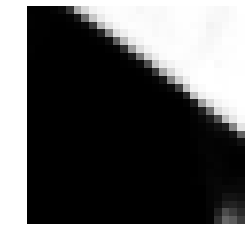

入力


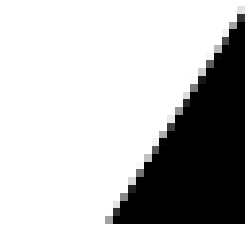

[[0.6605575 0.7578198]]
[[0. 0.]]
出力


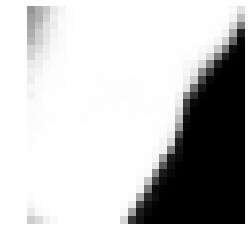

入力


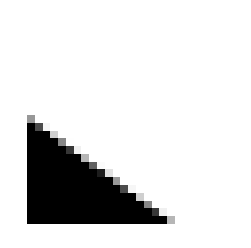

[[0.2854591 0.3827975]]
[[0. 0.]]
出力


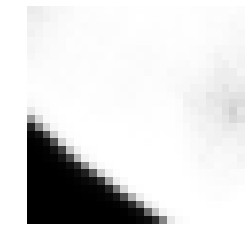

入力


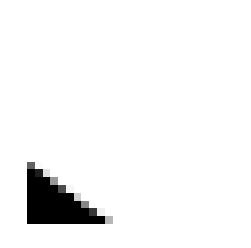

[[0.41779226 0.54715234]]
[[0. 0.]]
出力


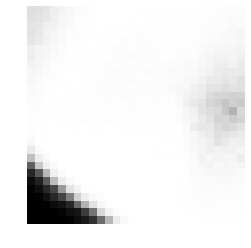

入力


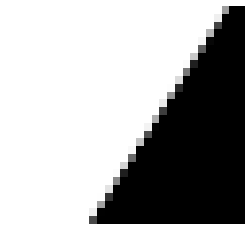

[[0.7804255  0.29659915]]
[[0. 0.]]
出力


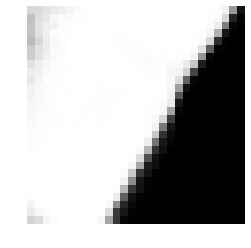

入力


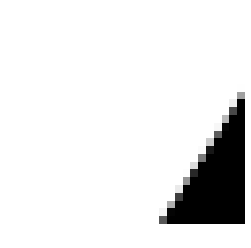

[[0.6562174 0.5707786]]
[[0. 0.]]
出力


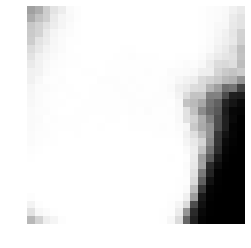

入力


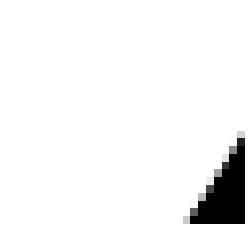

[[0.6732302  0.37374523]]
[[0. 0.]]
出力


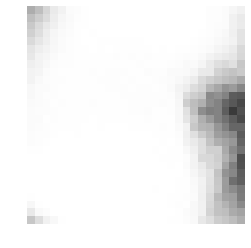

入力


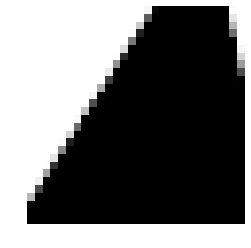

[[0.8307858  0.36646616]]
[[0. 0.]]
出力


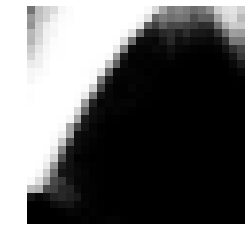

入力


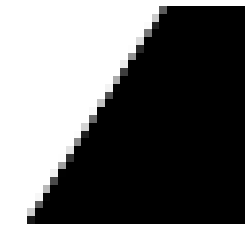

[[0.81667024 0.39455238]]
[[0. 0.]]
出力


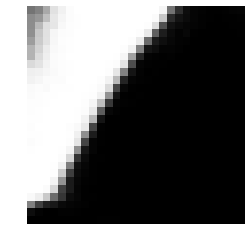

入力


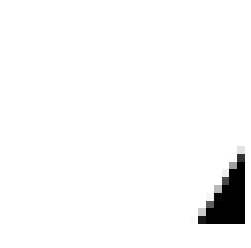

[[0.6633741  0.39294347]]
[[0. 0.]]
出力


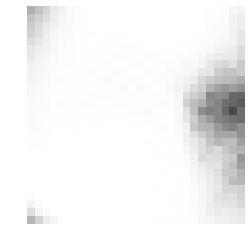

入力


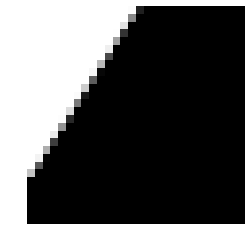

[[0.77075666 0.7041475 ]]
[[0. 0.]]
出力


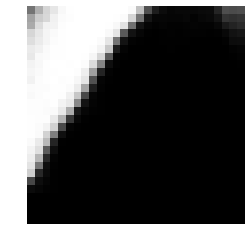

入力


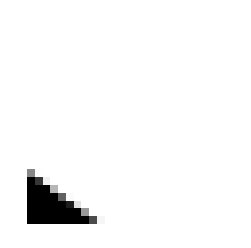

[[0.30717734 0.31058452]]
[[0. 0.]]
出力


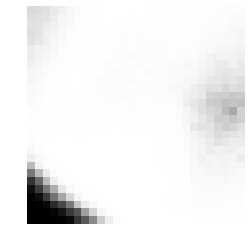

入力


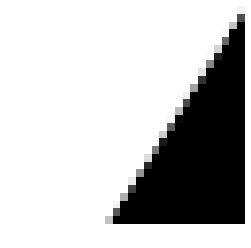

[[0.69771844 0.5829103 ]]
[[0. 0.]]
出力


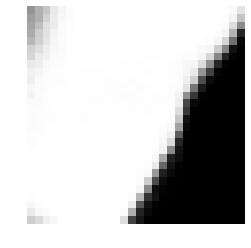

入力


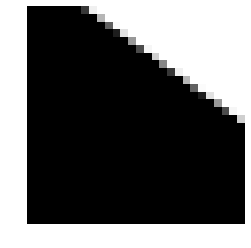

[[0.18767247 0.58961076]]
[[0. 0.]]
出力


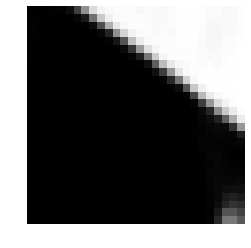

入力


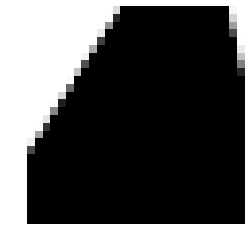

[[0.8386639 0.46895  ]]
[[0. 0.]]
出力


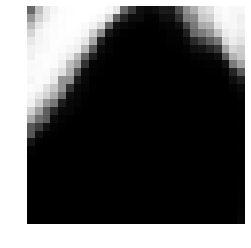

入力


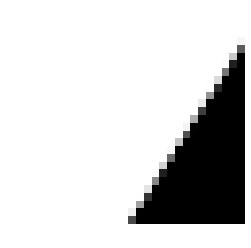

[[0.7491015  0.29772907]]
[[0. 0.]]
出力


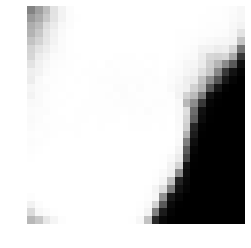

入力


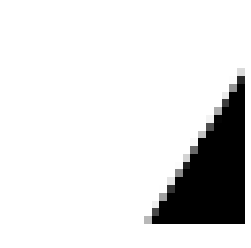

[[0.7215384 0.3024598]]
[[0. 0.]]
出力


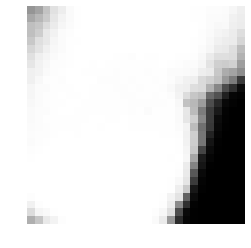

入力


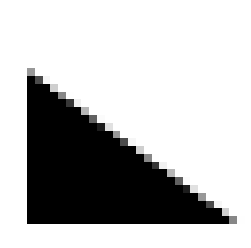

[[0.20335937 0.3429849 ]]
[[0. 0.]]
出力


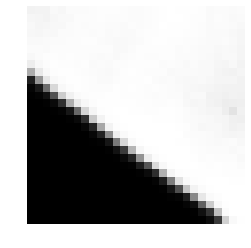

入力


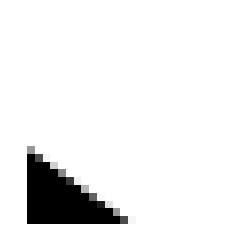

[[0.28349298 0.3067729 ]]
[[0. 0.]]
出力


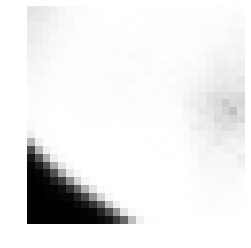

入力


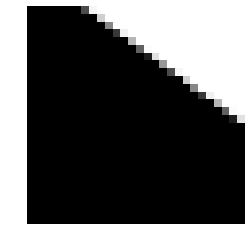

[[0.239277  0.6818252]]
[[0. 0.]]
出力


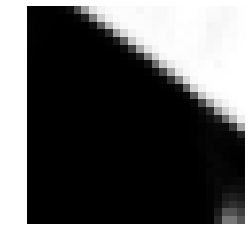

入力


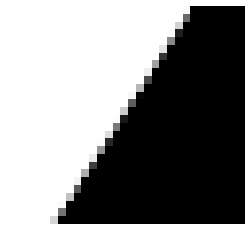

[[0.73063165 0.64564586]]
[[0. 0.]]
出力


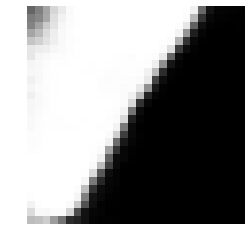

入力


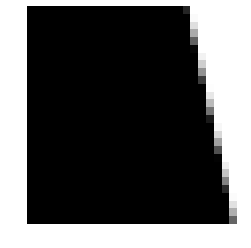

[[0.8927258  0.62024486]]
[[0. 0.]]
出力


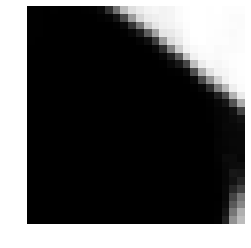

入力


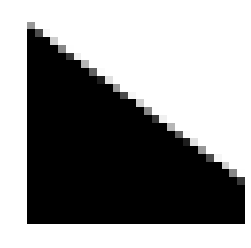

[[0.12438379 0.31564572]]
[[0. 0.]]
出力


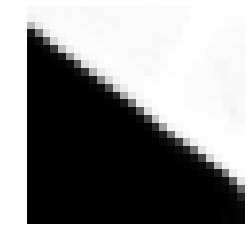

入力


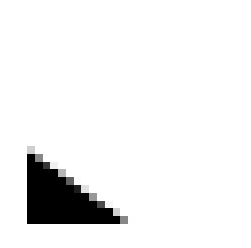

[[0.3849909  0.51264995]]
[[0. 0.]]
出力


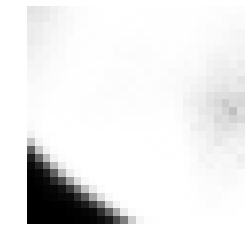

入力


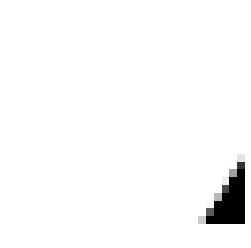

[[0.65898114 0.37716407]]
[[0. 0.]]
出力


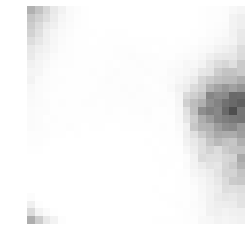

入力


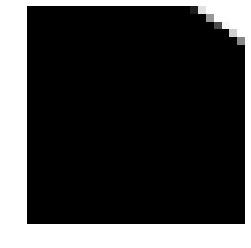

[[0.19634199 0.80906266]]
[[0. 0.]]
出力


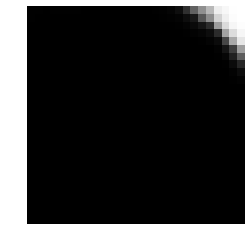

入力


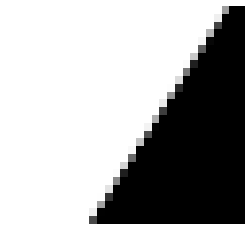

[[0.7795876 0.2988479]]
[[0. 0.]]
出力


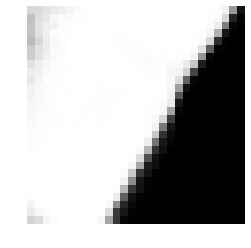

入力


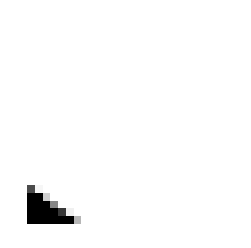

[[0.3658985  0.38914376]]
[[0. 0.]]
出力


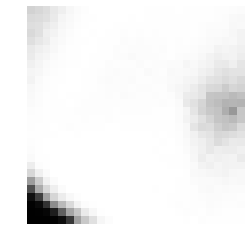

入力


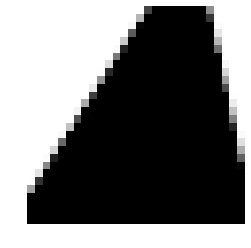

[[0.8441344  0.33395714]]
[[0. 0.]]
出力


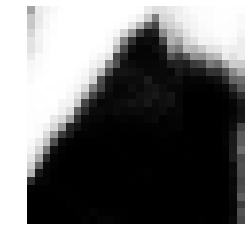

入力


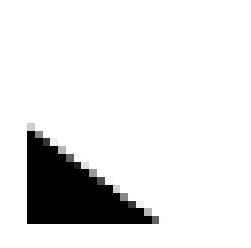

[[0.30064136 0.41177657]]
[[0. 0.]]
出力


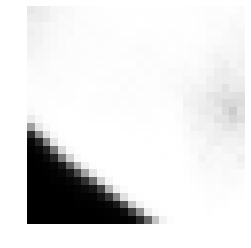

入力


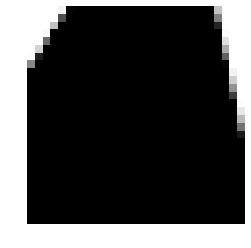

[[0.8623385  0.58834493]]
[[0. 0.]]
出力


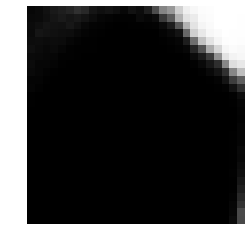

入力


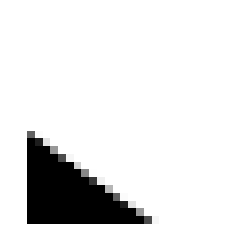

[[0.49910367 0.7963212 ]]
[[0. 0.]]
出力


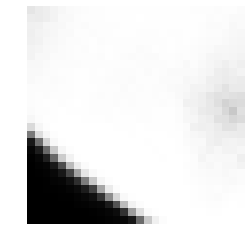

入力


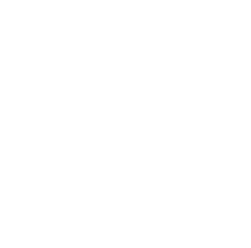

[[0.5483903  0.58445114]]
[[0. 0.]]
出力


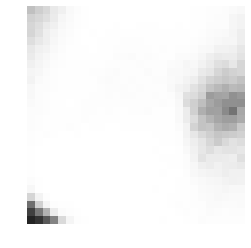

入力


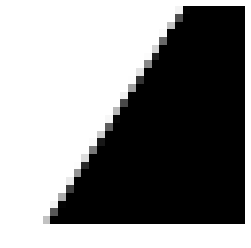

[[0.7528164  0.59624267]]
[[0. 0.]]
出力


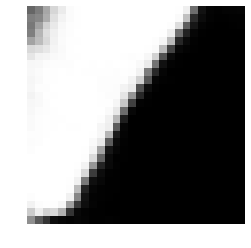

入力


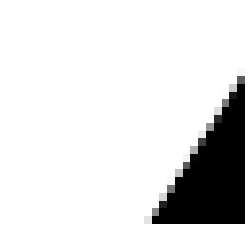

[[0.63368875 0.7028284 ]]
[[0. 0.]]
出力


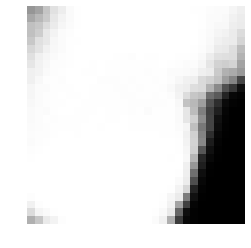

入力


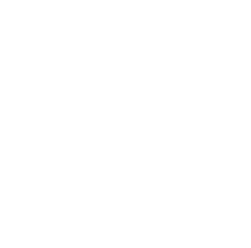

[[0.49818814 0.5312978 ]]
[[0. 0.]]
出力


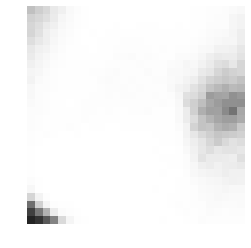

入力


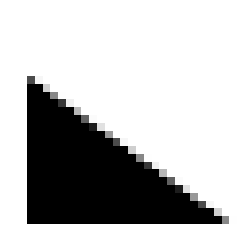

[[0.2896148  0.50548285]]
[[0. 0.]]
出力


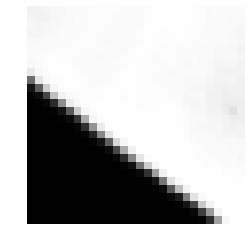

入力


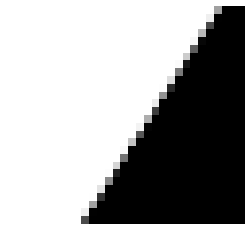

[[0.673043  0.7943749]]
[[0. 0.]]
出力


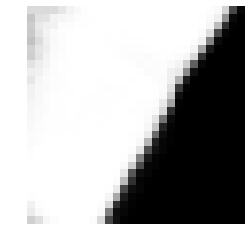

入力


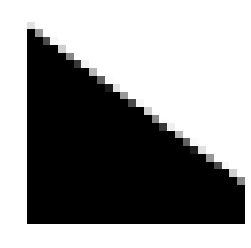

[[0.19559744 0.44725206]]
[[0. 0.]]
出力


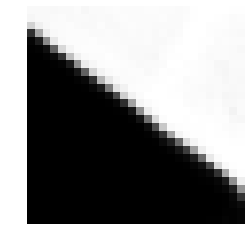

入力


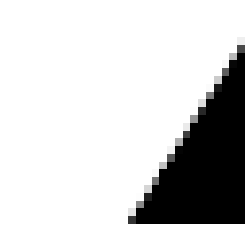

[[0.64555955 0.7229998 ]]
[[0. 0.]]
出力


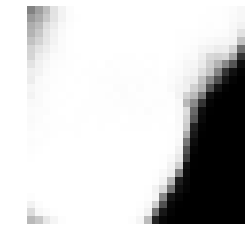

入力


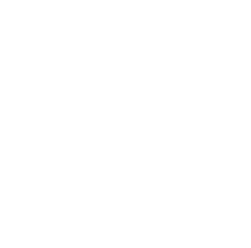

[[0.52674836 0.42702135]]
[[0. 0.]]
出力


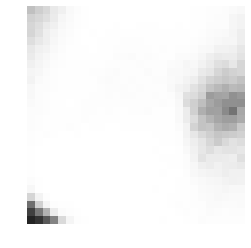

入力


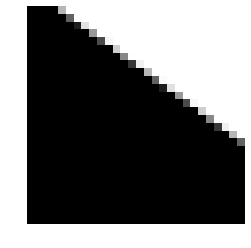

[[0.22475496 0.6013982 ]]
[[0. 0.]]
出力


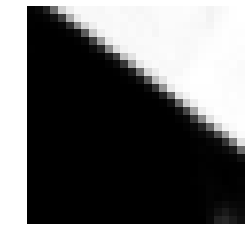

入力


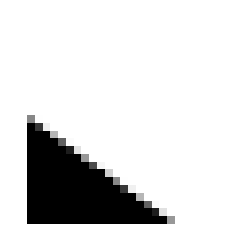

[[0.30742723 0.45779318]]
[[0. 0.]]
出力


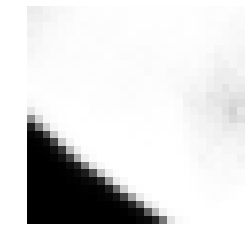

入力


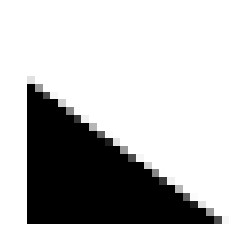

[[0.350597   0.63104194]]
[[0. 0.]]
出力


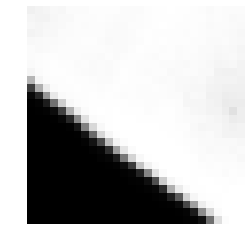

入力


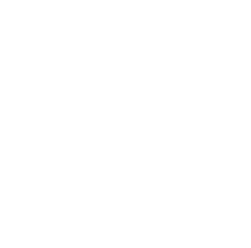

[[0.5304437 0.4141413]]
[[0. 0.]]
出力


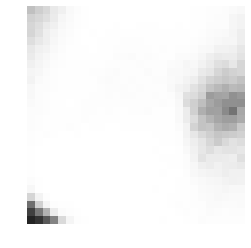

入力


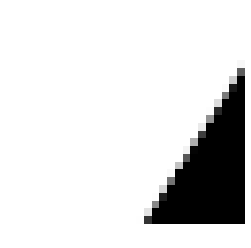

[[0.631829   0.72500634]]
[[0. 0.]]
出力


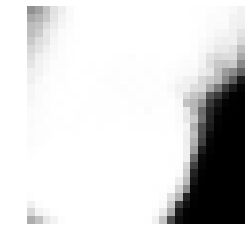

入力


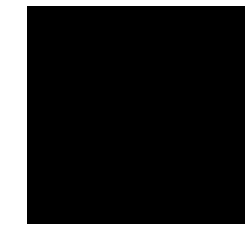

[[0.10699142 0.7425219 ]]
[[0. 0.]]
出力


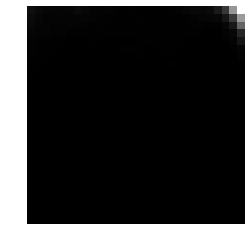

入力


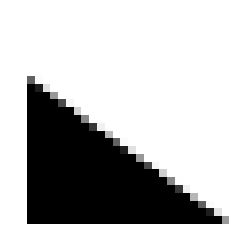

[[0.2598675  0.44633323]]
[[0. 0.]]
出力


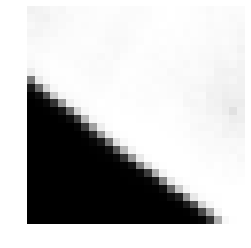

入力


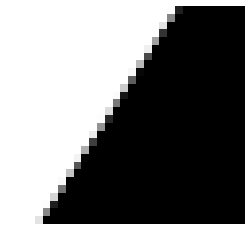

[[0.7313935  0.71388906]]
[[0. 0.]]
出力


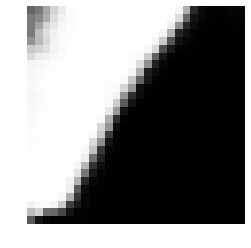

入力


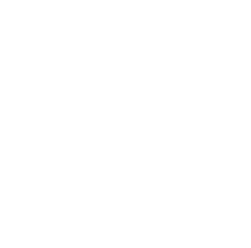

[[0.5443428  0.38725188]]
[[0. 0.]]
出力


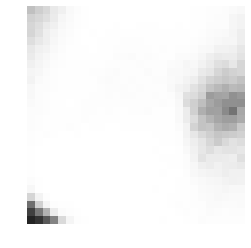

入力


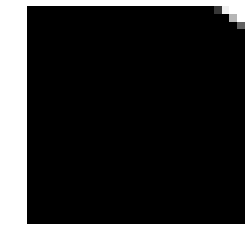

[[0.14534914 0.7579632 ]]
[[0. 0.]]
出力


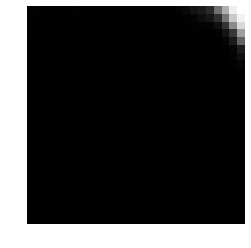

入力


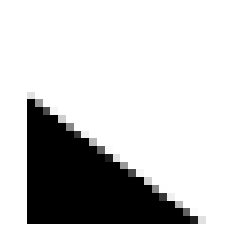

[[0.27240604 0.43769914]]
[[0. 0.]]
出力


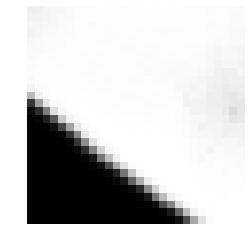

入力


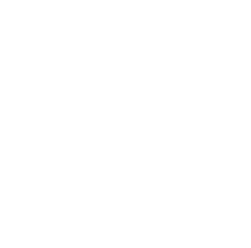

[[0.5571201 0.5484197]]
[[0. 0.]]
出力


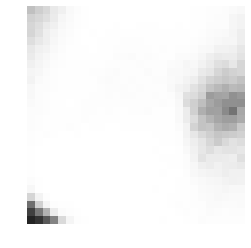

入力


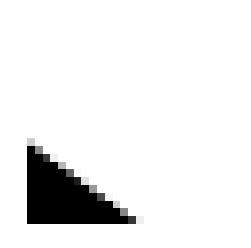

[[0.30363035 0.36785287]]
[[0. 0.]]
出力


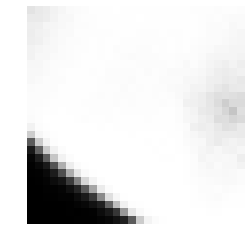

入力


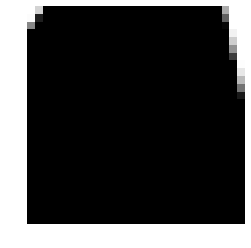

[[0.85950506 0.6831431 ]]
[[0. 0.]]
出力


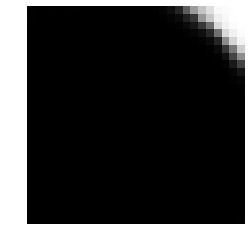

In [11]:
from defCVAE_selfdata import CVAE
'''
INPUT_SIZE = 784
HIDDEN_SIZE = 128
Z_SIZE = 2
MINIBATCH_SIZE = 100
LABEL_SIZE = 2
'''
MODEL_PATH = './CVAE_{0}_{1}.model'.format(EPOCH_NUM, Z_SIZE)

model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
chainer.serializers.load_npz(MODEL_PATH, model)

index = 77
for index in range(100):
    print('入力')
    pixels = (Xy_test[index][0] * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray',vmin=0.0)
    plt.axis("off")
    plt.show()
    print(L_test[[index]])
    print(L_test[[index]]*0)
    test_decode(model, X_test[[index]], np.array(L_test[[index]]*0, dtype='float32'), MODEL_PATH )

# 画像が潜在空間のどこに分布しているのか表示

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

float32
float32
mu size:(200, 2)
logvar size:(200, 2)


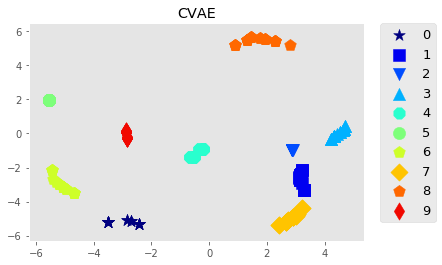

In [24]:
model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
chainer.serializers.load_npz(MODEL_PATH, model)
#print(Xy_test)
#print(L_dtest[20])
test_plot(model, Xy_dtest[0:len(Xy_dtest)], L_dtest[0:len(L_dtest)])


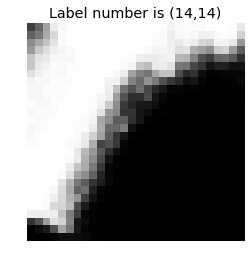

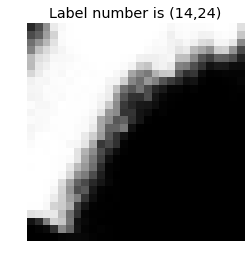

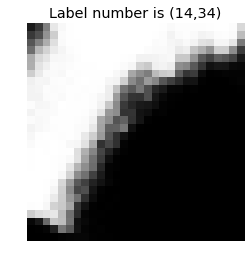

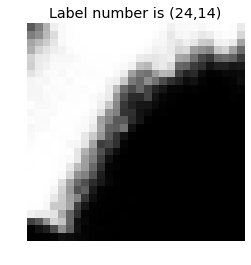

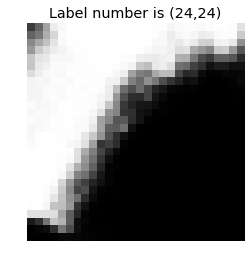

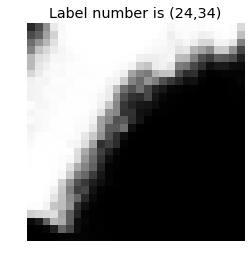

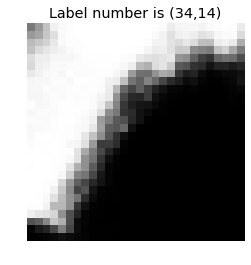

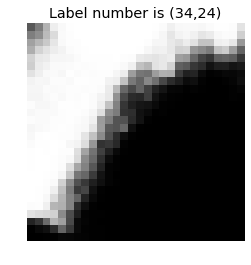

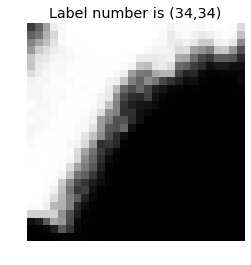

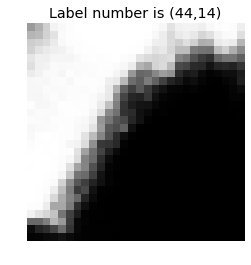

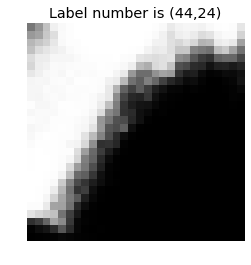

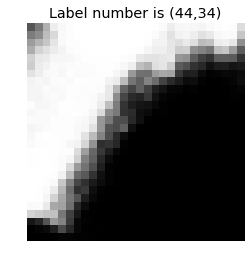

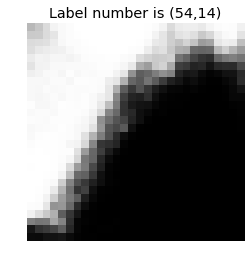

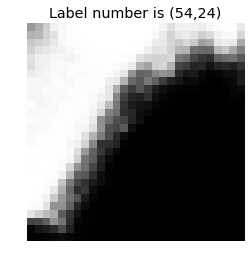

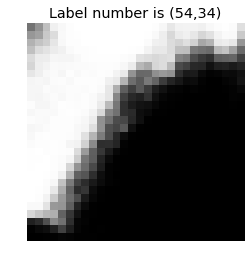

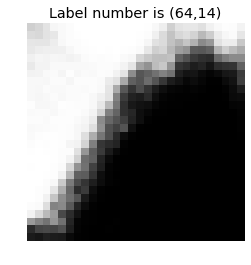

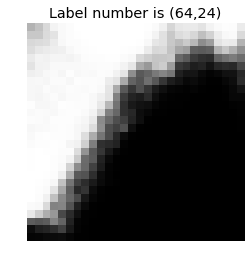

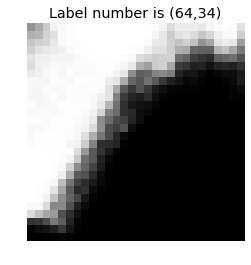

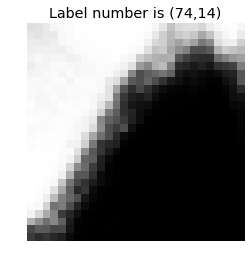

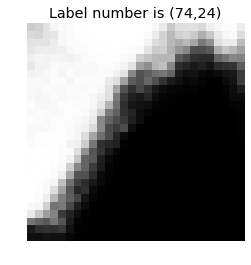

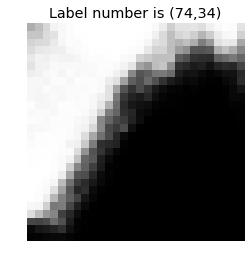

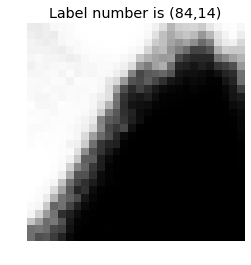

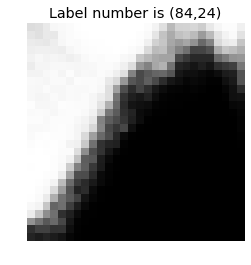

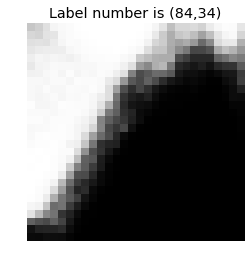

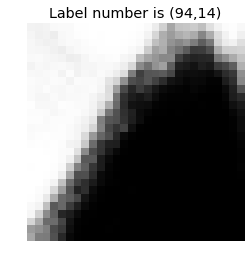

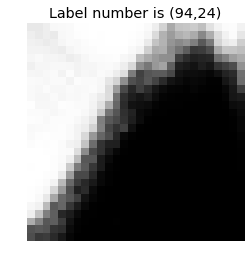

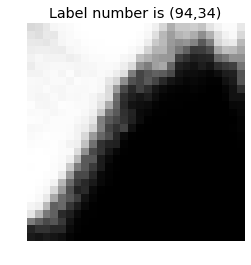

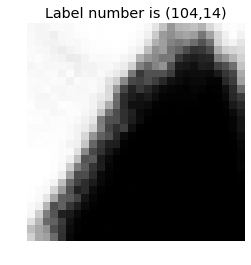

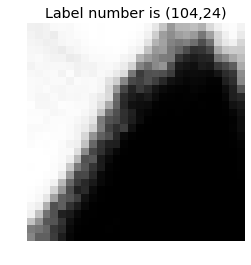

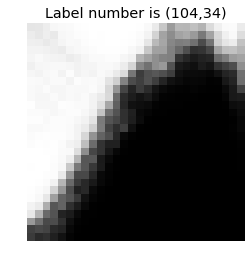

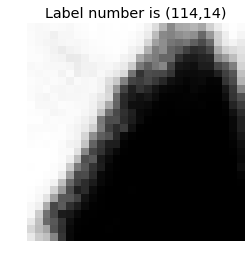

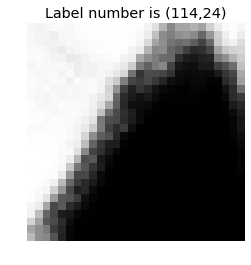

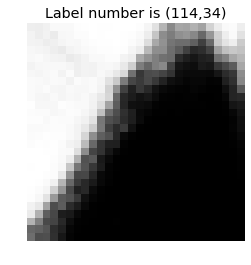

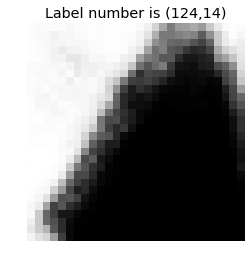

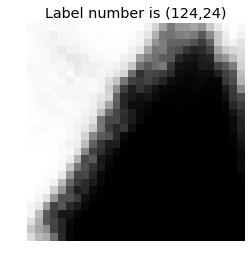

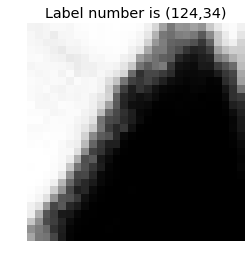

In [17]:
'''
nx = ny = 3
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

cnt = 0
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #print("\r cnt={}/{}".format(cnt, nx*ny), end=""); cnt += 1
        # draw images from randomly sampled z
        z = chainer.Variable(np.array([[xi, yi]], dtype=np.float32)) 
        x_mean = model.decode(z,np.array([[14,14]], dtype='float32'),True)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = (x_mean*255).data.astype(np.int32).reshape(28,28)
        
canvas_cpu = chainer.cuda.to_cpu(canvas)

plt.figure(figsize=(10, 15))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas_cpu, origin="upper", cmap="gray")
plt.tight_layout()
plt.savefig("mapping.png")


nx = ny = 30
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

cnt = 0
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #print("\r cnt={}/{}".format(cnt, nx*ny), end=""); cnt += 1
        # draw images from randomly sampled z
        z = chainer.Variable(np.array([[xi, yi]], dtype=np.float32)) 
        x_mean = model.decode(z,np.array([[70,14]], dtype='float32'),True)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = (x_mean*255).data.astype(np.int32).reshape(28,28)
        
canvas_cpu = chainer.cuda.to_cpu(canvas)

plt.figure(figsize=(10, 15))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas_cpu, origin="upper", cmap="gray")
plt.tight_layout()
plt.savefig("mapping.png")
'''
#z = chainer.Variable(np.array([[3, -2]], dtype=np.float32)) 
z = chainer.Variable(np.array([[-2, 0]], dtype=np.float32)) 
for p1 in range(14,126,10):
    for p2 in range(14,42,10):
        x_mean = model.decode(z,np.array([[float(p1)/(28*5),float(p2)/(28*2)]], dtype='float32'),True)
        x_mean = np.reshape(x_mean.data, (28,28))
        dispImage(x_mean,p1, p2)